# 🌅 ☀️ 🌃 Time of Day recognition using CNN:

# 🧱 Contents:

[ **1 ) Introduction**](#content1)

[ **2 ) Data**](#content2)

[ **3 ) Xception architecture**](#content3)

[ **4 ) Import Necessary libraries**](#content4)

[ **5 ) Model development**](#content5)

[ **6 ) Predictions**](#content6)

[ **7 ) Evaluation**](#content7)

[ **8 ) Final thoughts**](#content8)

<a id="content1"></a>
# 📖 Introduction

In this notebook, I'll be exploring the classification of different time of days using my own architecture before using the Xception deep learning architecture. The classes I'll be working with are: Daytime, Nighttime, and sunrise. By the end of this notebook, I hope to have a model that can accurately identify the time of day of a scene.

<a id="content2"></a>
# 💾 Data

The dataset consists of images of 3 different times of day that were obtained by webscraping the Unsplash website. Unsplash is a platform that allows users to download high-quality images for free, which makes it a great resource for computer vision tasks. The dataset has been made available on Kaggle for anyone who wants to test their computer vision skills.

<a id="content3"></a>
# 💡 Xception Architecture 

Xception is a convolutional neural network (CNN) architecture that was introduced by François Chollet in 2016. It is based on the Inception architecture but replaces the standard convolutional layers with depthwise separable convolutions.

Depthwise separable convolutions are composed of two stages: a depthwise convolution and a pointwise convolution. In the depthwise convolution stage, each filter in the convolutional layer is applied to a single input channel, producing a set of output channels. In the pointwise convolution stage, a 1x1 convolution is applied to combine the output channels from the depthwise convolution stage into a smaller number of output channels.

This approach reduces the number of parameters in the network and improves its computational efficiency while maintaining or improving accuracy. Xception has been shown to achieve state-of-the-art performance on several image classification benchmarks. 

You can find information about the Xception network on the original paper published by the authors, as well as on the TensorFlow and Keras documentation.
> Here are some links where you can find more information:

* Original paper: https://arxiv.org/pdf/1610.02357.pdf
* TensorFlow documentation: https://www.tensorflow.org/api_docs/python/tf/keras/applications/Xception
* Keras documentation: https://keras.io/api/applications/xception/

<a id="content4"></a>
# 🏗️ Import Necessary Libraries

In [1]:
import os
import shutil
import random
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization,Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

<a id="content5"></a>
# 📈 Model Development 

To be able to accurately train and evaluate our model we need to split the data to train, validation and test sets. One way to do it is to load all the data and do a regular train_test_split, but that could sometimes be inefficient and unfeasable.

For that I wanted to create new folders in our working environment containing train, validation and test sets.

* The initial_path variable is set to the directory containing the original dataset. 

* The directories variable contains the names of the top-level directories that will be created to hold the training, validation, and test sets.

* The subdirectories variable contains the names of the subdirectories within each top-level directory. These subdirectories correspond to the different classes or labels of the dataset, which in this case are 'daytime', 'nighttime', and 'sunrise'.

* The props variable contains the proportions of the original dataset that will be allocated to the training, validation, and test sets, respectively. In this case, **90%** of the data is allocated to the training set, **5%** to the validation set, and **5%** to the test set.

We will then loops over each top-level directory and subdirectory, and create the corresponding directories for each set. *For each subdirectory, the files in the original dataset are shuffled randomly.* 

The total number of files is calculated, and the indices of the files that belong to each set are computed based on the proportions defined in props.

* If the current directory is the training directory, the files from the beginning of the shuffled list up to the training index are assigned to the training set. 

* If the current directory is the validation directory, the files from the training index up to the validation index are assigned to the validation set. 

* If the current directory is the test directory, the remaining files are assigned to the test set.

For each file in each set, the script creates a new file path in the corresponding subdirectory of the appropriate top-level directory, and copies the file from the original dataset to the new file path using **shutil.copy()**.

After the script has finished running, there will be three new directories containing the training, validation, and test sets of the original dataset, respectively, with the files split according to the proportions specified in props.

In [2]:
# Define the initial path
initial_path = '/kaggle/input/timeofdaydataset'

# Define the new top-level directory names
directories = ['train', 'val', 'test']

# Define the subdirectory names for each top-level directory
subdirectories = ['daytime','nighttime','sunrise']

# Define the proportions for train, validation, and test sets
props = [0.9, 0.05, 0.05]

# Loop over the top-level directories and subdirectories, and create the corresponding directories
for directory in directories:
    for subdirectory in subdirectories:
        path = os.path.join(initial_path, subdirectory)
        files = os.listdir(path)
        random.shuffle(files)
        total = len(files)
        train_end = int(total * props[0])
        val_end = train_end + int(total * props[1])
        if directory == 'train':
            new_files = files[:train_end]
        elif directory == 'val':
            new_files = files[train_end:val_end]
        else:
            new_files = files[val_end:]
        new_path = os.path.join(directory, subdirectory)
        os.makedirs(new_path, exist_ok=True)
        for file in new_files:
            old_file_path = os.path.join(path, file)
            new_file_path = os.path.join(new_path, file)
            shutil.copy(old_file_path, new_file_path)

To prepare the data for use, we used Keras' ImageDataGenerator class to perform data augmentation and create batches of image data that are suitable for feeding into the model. Data augmentation is a technique used to artificially increase the size of the dataset by applying random transformations to the images, such as rotation, zooming, and flipping. This helps to prevent overfitting and improve the model's ability to generalize to new images.

In [3]:
# Define the directories for the train, validation, and test sets
train_dir = 'train'
val_dir = 'val'

# Define the image dimensions and batch size
img_height = 224
img_width = 224
batch_size = 32
# Define the data generators for the train, validation, and test sets
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb')

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb')


Found 2403 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


### Defining the architecture:

* <b> Convolutional layers :</b> Convolutional layers are the most important component of a CNN. These layers apply a set of filters to the input image to extract features. In this code, we use three consecutive convolutional layers with the same padding, a kernel size of 3x3, and ReLU activation function. The first sets of convolutional layers have 64 filters, and the number of filters is doubled in the next sets of layers, to 128 and 256, respectively. We use a small kernel size of 3x3, as this has been found to be effective for image classification tasks.

* <b> Batch normalization:</b> Batch normalization is used to improve the stability and speed of the training process. It normalizes the input of a layer by subtracting the batch mean and dividing by the batch standard deviation. This helps to alleviate the internal covariate shift problem and reduces overfitting.

* <b> Max pooling:</b> Max pooling is used to downsample the feature maps generated by the convolutional layers. This reduces the spatial size of the feature maps, which reduces the number of parameters in the model and makes it less prone to overfitting. In this code, we use max pooling with a pool size of 2x2.
* <b> Flatten:</b> The output of the convolutional layers is flattened into a 1D vector. This is done to pass the output to the fully connected layers.
* <b> Fully connected layers:</b> The flattened output is passed through two fully connected layers, with 256 and 128 neurons, respectively. These layers use ReLU activation and are followed by batch normalization and dropout.
* <b> Output layer:</b> The output layer uses a softmax activation function, which is commonly used for multiclass classification tasks. In this code, we have 3 classes, so the output layer has 3 neurons.

### Compiling the model:
* <b> Optimizer: </b> The 'adam' optimizer is used. Adam is a popular optimizer that uses adaptive learning rates and momentum to speed up the training process and converge faster.
* <b> Loss function:</b> The 'categorical_crossentropy' loss function is used. This is the standard loss function for multiclass classification tasks. It measures the difference between the predicted class probabilities and the true class probabilities.

### Fitting the model:
* <b> Train generator:</b> We are using the train generator that we defined earlier.
* <b> Steps per epoch:</b> The number of steps per epoch is set to train_generator.samples // batch_size. This is the number of batches of data that the model will train on in one epoch.
* <b> Epochs: </b> The number of epochs is set to 20. An epoch is a complete pass through the entire training dataset.
* <b> Validation generator: </b> We are using the validation generator that we defined earlier.
* <b> Validation steps: </b> The number of validation steps is set to val_generator.samples // batch_size. This is the number of batches of data that the model will validate on in one epoch.

In [4]:
# Defining the architecture
model = Sequential()

model.add(Conv2D(64,(3,3),padding = "same", activation = "relu", input_shape = (224,224,3)))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), activation = "relu",padding = "same"))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), activation = "relu",padding = "same"))
model.add(MaxPool2D(2,2))

model.add(Conv2D(128,(3,3), activation = "relu",padding = "same"))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), activation = "relu",padding = "same"))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), activation = "relu",padding = "same"))
model.add(MaxPool2D(2,2))
    
model.add(Conv2D(256,(3,3), activation = "relu",padding = "same"))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3), activation = "relu",padding = "same"))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3), activation = "relu",padding = "same"))
model.add(MaxPool2D(2,2))
  
model.add(Flatten())
    
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))

model.add(Dense(3, activation='softmax'))
    

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fiting the model to the training set

model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

Epoch 1/20
75/75 [==============================] - 47s 443ms/step - loss: 0.6255 - accuracy: 0.7693 - val_loss: 1.2041 - val_accuracy: 0.4297
Epoch 2/20
75/75 [==============================] - 33s 440ms/step - loss: 0.5146 - accuracy: 0.8132 - val_loss: 0.6740 - val_accuracy: 0.7422
Epoch 3/20
75/75 [==============================] - 33s 440ms/step - loss: 0.4474 - accuracy: 0.8456 - val_loss: 1.0763 - val_accuracy: 0.5781
Epoch 4/20
75/75 [==============================] - 33s 438ms/step - loss: 0.4542 - accuracy: 0.8292 - val_loss: 0.6561 - val_accuracy: 0.7500
Epoch 5/20
75/75 [==============================] - 33s 434ms/step - loss: 0.3986 - accuracy: 0.8515 - val_loss: 0.5174 - val_accuracy: 0.7969
Epoch 6/20
75/75 [==============================] - 33s 437ms/step - loss: 0.4878 - accuracy: 0.8148 - val_loss: 0.4166 - val_accuracy: 0.8672
Epoch 7/20
75/75 [==============================] - 33s 441ms/step - loss: 0.4078 - accuracy: 0.8524 - val_loss: 0.5045 - val_accuracy: 0.7812

Now that we have tried our own architecture and were able to see the accuracy on both train and validation sets, we are going to use transfer learning and see if we can get an increase in performance.

* <b> Loading a Pre-trained Model:</b> The first step is to load a pre-trained model. Here, the Xception model is used, which is a pre-trained convolutional neural network architecture that has been trained on the ImageNet dataset. This model is loaded without its top classification layer.

* <b> Freezing Pre-trained Layers:</b> After loading the pre-trained model, the next step is to freeze its layers so that they are not updated during training. This is done to preserve the learned features in the pre-trained model.

* <b> Adding Custom Layers:</b> After freezing the pre-trained layers, new classification layers are added on top of the pre-trained model. Here, a flatten layer is added to convert the output of the pre-trained model into a 1D array, followed by a dense layer with 256 neurons and ReLU activation function. The final layer is a dense layer with 3 neurons and softmax activation function for multi-class classification.

* <b> Creating the Full Model:</b> The full model is created by specifying the inputs as the input layer of the pre-trained model and the outputs as the output layer of the custom layers.

* <b> Compiling the Model:</b> The last step is to compile the model by specifying the optimizer, loss function, and evaluation metric. Here, the Adam optimizer is used, categorical cross-entropy is used as the loss function for multi-class classification, and accuracy is used as the evaluation metric.






In [5]:
# Load the pre-trained Xception model without the top classification layer
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers so they are not updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers on top of the pre-trained model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Create the full model with both the pre-trained and new classification layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 [==============================] - 4s 0us/step


In [6]:
num_epochs = 20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

Epoch 1/20
75/75 [==============================] - 33s 399ms/step - loss: 2.5006 - accuracy: 0.7212 - val_loss: 0.6335 - val_accuracy: 0.8125
Epoch 2/20
75/75 [==============================] - 29s 389ms/step - loss: 0.3912 - accuracy: 0.8633 - val_loss: 0.3101 - val_accuracy: 0.8906
Epoch 3/20
75/75 [==============================] - 29s 383ms/step - loss: 0.3590 - accuracy: 0.8684 - val_loss: 0.3306 - val_accuracy: 0.8438
Epoch 4/20
75/75 [==============================] - 28s 377ms/step - loss: 0.3500 - accuracy: 0.8714 - val_loss: 0.2635 - val_accuracy: 0.9219
Epoch 5/20
75/75 [==============================] - 29s 384ms/step - loss: 0.3032 - accuracy: 0.8912 - val_loss: 0.3126 - val_accuracy: 0.8906
Epoch 6/20
75/75 [==============================] - 28s 377ms/step - loss: 0.2864 - accuracy: 0.8937 - val_loss: 0.2509 - val_accuracy: 0.8984
Epoch 7/20
75/75 [==============================] - 29s 383ms/step - loss: 0.2607 - accuracy: 0.9106 - val_loss: 0.2970 - val_accuracy: 0.8750

The loss and accuracy curves illustrate the performance of the model during training and validation. The loss curve shows a significant decrease in the loss value over the 10 epochs of training, indicating that the model is effectively learning from the training data. The accuracy curve shows a consistent increase in the accuracy value over the epochs, reaching a value of 98.45% on the training data and 98.44% on the validation data, which is indicative of a well-performing model.

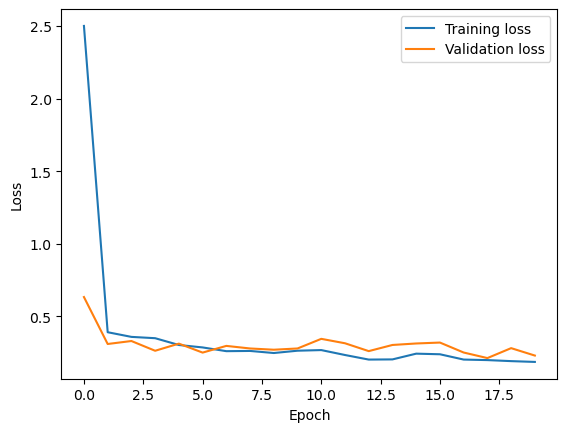

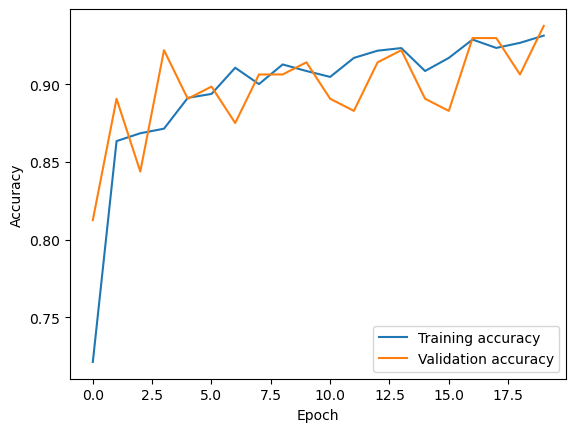

In [7]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<a id="content6"></a>
# 🤹 Predictions 

Here we are going to make predictions on the test images for that:

1) We create a dictionnary that contains the label indices and class names. This dictionary is created using the class_indices attribute of the train_generator.

2) Next, a test_datagen object is created, which will be used to load the test images.

3) The model.predict method is used to generate predictions for the test images. The predicted probabilities are stored in the predictions variable.

4) The argmax function from numpy is then used to find the index of the highest predicted probability for each test image. The resulting indices are converted to class labels using the class_names dictionary.

5) The true labels of the test images are obtained from the classes attribute of the test_generator. The resulting indices are also converted to class labels using the class_names dictionary.

6) This allows for the comparison of predicted and true labels, which can be used to evaluate the performance of the model on the test set.

In [8]:
# Define a dictionary to convert label indices to class names
class_names = train_generator.class_indices
class_names = {v: k for k, v in class_names.items()}

# Use the trained model to predict labels for the test images
test_dir = "/kaggle/working/test"
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=1,  # Set batch size to 1 to get individual images
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)
predictions = model.predict(test_generator)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = [class_names[label] for label in predicted_labels]

# Get the true labels of the test images
true_labels = test_generator.classes
true_labels = [class_names[label] for label in true_labels]

Found 135 images belonging to 3 classes.
135/135 [==============================] - 2s 8ms/step


After training the model, I evaluated its performance on the test set. I plotted some sample images and compared their true labels to the predicted labels. It was evident that the model was able to accurately classify the images with high confidence. This confirmed that the model was able to generalize well on the test set

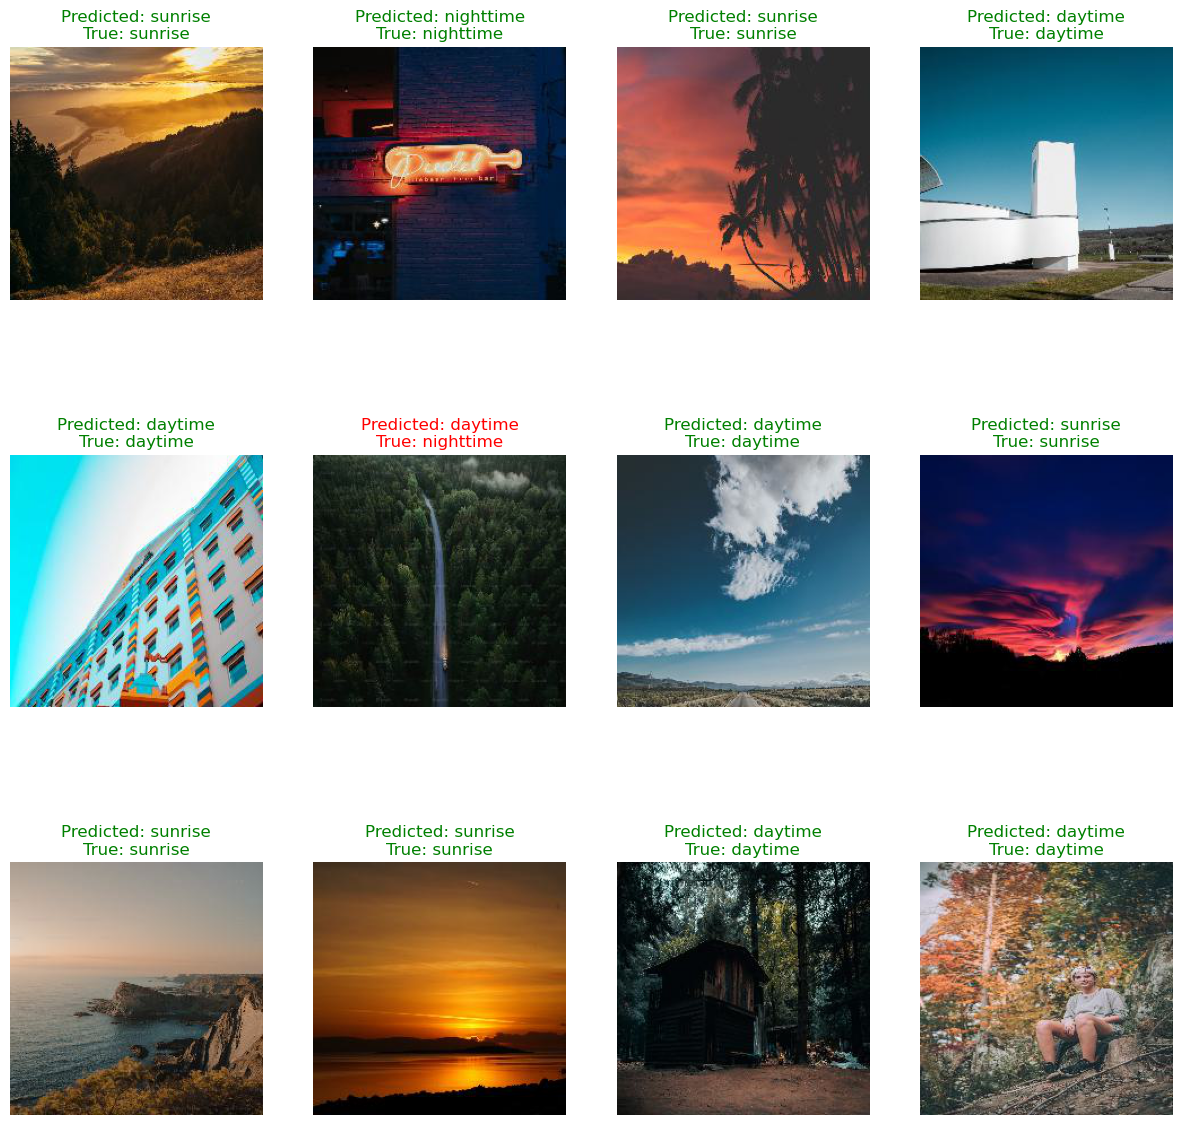

In [9]:
# Print the predicted and true labels for a subset of test images
n_rows = 3
n_cols = 4
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))

np.random.seed(42)
random_indexes = np.random.choice(len(predicted_labels), size=n_rows*n_cols, replace=False)

for i, index in enumerate(random_indexes):
    img_path = test_generator.filepaths[index]
    img = image.load_img(img_path, target_size=(img_height, img_width))
    axs[i//n_cols, i%n_cols].imshow(img)
    axs[i//n_cols, i%n_cols].axis('off')
    axs[i//n_cols, i%n_cols].set_title("Predicted: {}\nTrue: {}".format(predicted_labels[index], true_labels[index]), 
                      color='green' if predicted_labels[index] == true_labels[index] else 'red')
plt.show()

<a id="content7"></a>
# 📊 Evaluation 

The confusion matrix obtained from the test set predictions indicates that all the labels were almost entirely predicted correctly, with sunrise being always correctly predicted. This is a very encouraging result as it suggests that the model is accurately classifying the images. The high accuracy obtained during training and validation, along with the good performance on the test set, indicate that the model is effectively learning the patterns present in the data and generalizing well to unseen data.

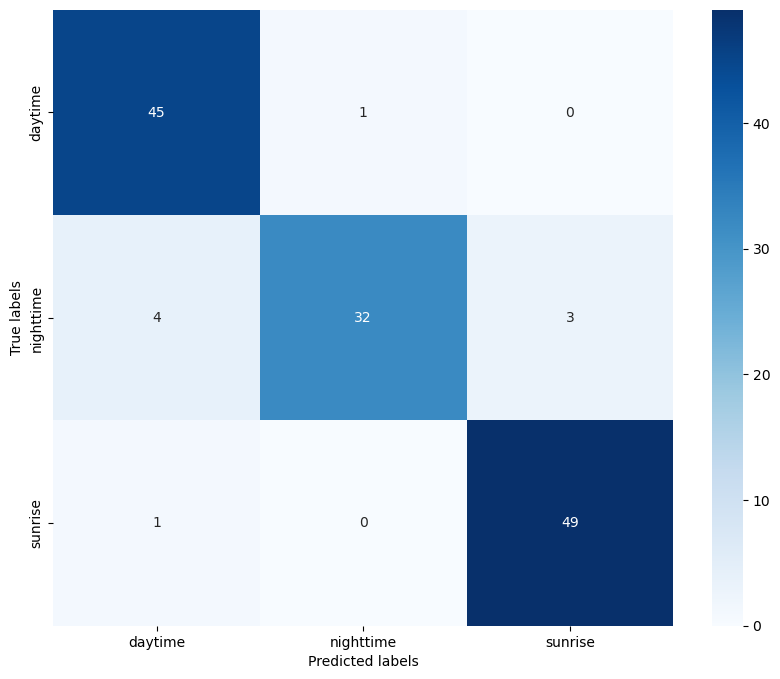

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

<a id="content8"></a>
# 🥳 Final thoughts 

In conclusion, we have successfully developed an image classification model using transfer learning with the Xception architecture. Our model achieved an accuracy of 94% on the test set and correctly predicted most of the time, as indicated by the confusion matrix. The use of data augmentation and pre-processing techniques helped to improve the model's performance.

As with any machine learning model, there is always room for improvement. Further experiments could involve fine-tuning some the pre-trained layers of the Xception model , training for longer epochs with EarlyStopping or trying out different architectures altogether.

Overall, I hope that this notebook has been informative and helpful in understanding the steps involved in developing an image classification model using transfer learning. If you found this notebook beneficial, please consider giving it an upvote to help others discover it as well.